### 1. Load the dataset

**[1.1] Automatic reload modules**

In [208]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**[1.2] Import packages**

In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**[1.3] Load the datasets**

In [210]:
df_train = pd.read_csv('../data/raw/train.csv', low_memory=False)
df_test = pd.read_csv('../data/raw/test.csv', low_memory=False)

### 2. Explore the data

**[2.1] Display all columns and rows in dataframe**

In [211]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

**[2.2] Summary statstics**

In [212]:
# !pip install jupyter-summarytools

In [213]:
# from summarytools import dfSummary
# dfSummary(df_train)

**[2.3] Remove unclear/ invalid attributes**

* Since definitions of "ftr" and "pfr" are unclear, the attributes will be eliminated from the analysis. 'ht' consists of multiple invalid values, the variable will also be removed. The high cardinality involved in 'num' will be removed.

In [214]:
df_train = df_train.drop(['ftr', 'pfr', 'num', 'ht'], axis=1).reset_index(drop=True)
df_test = df_test.drop(['ftr', 'pfr', 'num', 'ht'], axis=1).reset_index(drop=True)

**Save a copy of data before cleaning**

In [215]:
df_train2 = df_train.copy()
df_test2 = df_test.copy()

**[2.4] Handle missing values**

In [216]:
# #Visualize by heatmap
# plt.figure(figsize=(10,6))
# sns.heatmap(df_train2.isnull(), yticklabels=False, xticklabels=True, cbar=False, cmap='plasma')
# plt.xticks(rotation=90)
# plt.title('Missing values heatmap', size=14, color='grey')
# plt.tight_layout()
# plt.show()

In [217]:
# #Count missing values
# num=df_train2.select_dtypes(include = np.number).columns
# num2=df_test2.select_dtypes(include = np.number).columns

# cnt = df_train2[num].isna().sum()
# per = ((cnt/df_train2.shape[0])*100).round(4)

# cnt2 = df_test2[num2].isna().sum()
# per2 = ((cnt2/df_test2.shape[0])*100).round(4)

# missing_cnt = pd.concat([per, per2], axis=1, keys=['Missing_Percent__train', 'Missing_Percent__test'])
# missing_cnt.sort_values(['Missing_Percent__train', 'Missing_Percent__test'], ascending=False)

* Since attributes dunks_ratio contain over 50% of missing values, the entire column will be dropped to avoid inappropriate imputation. Regarding pick and Rec_Rank, these features would be significant predictors. They will be replaced with zero and created binary features to distinguish.

In [218]:
df_train2 = df_train2.drop(['dunks_ratio'], axis=1)
df_test2 = df_test2.drop(['dunks_ratio'], axis=1)

**Pick and Rec_Rank - fill missing values and create encoded features**

In [219]:
df_train2['pick'] = df_train2['pick'].fillna(0)
df_test2['pick'] = df_test2['pick'].fillna(0)

df_train2['Rec_Rank'] = df_train2['Rec_Rank'].fillna(0)
df_test2['Rec_Rank'] = df_test2['Rec_Rank'].fillna(0)


df_train2['Picked'] = (df_train2['pick'] > 0).astype(int)
df_test2['Picked'] = (df_test2['pick'] > 0).astype(int)

df_train2['Recruited'] = (df_train2['Rec_Rank'] > 0).astype(int)
df_test2['Recruited'] = (df_test2['Rec_Rank'] > 0).astype(int)


* As some of the variables are right-skewed, the missing values will be replaced with the median.

**Fill missing values with median**

In [220]:
for col in df_train2.select_dtypes(include=np.number).columns:
    df_train2[col] = df_train2[col].fillna(df_train2[col].median())

for col in df_test2.select_dtypes(include=np.number).columns:
    df_test2[col] = df_test2[col].fillna(df_test2[col].median())


**Check if missing values are addressed**

In [221]:
num=df_train2.select_dtypes(include = np.number).columns
num2=df_test2.select_dtypes(include = np.number).columns

cnt = df_train2[num].isna().sum()
per = ((cnt/df_train2.shape[0])*100).round(4)

cnt2 = df_test2[num2].isna().sum()
per2 = ((cnt2/df_test2.shape[0])*100).round(4)

missing_cnt = pd.concat([per, per2], axis=1, keys=['Missing_Percent__train', 'Missing_Percent__test'])
missing_cnt.sort_values(['Missing_Percent__train', 'Missing_Percent__test'], ascending=False)
missing_cnt[missing_cnt['Missing_Percent__train']>0]

,Missing_Percent__train,Missing_Percent__test


**[2.5] Handling outliers**

**Use boxplots to detect outliers**

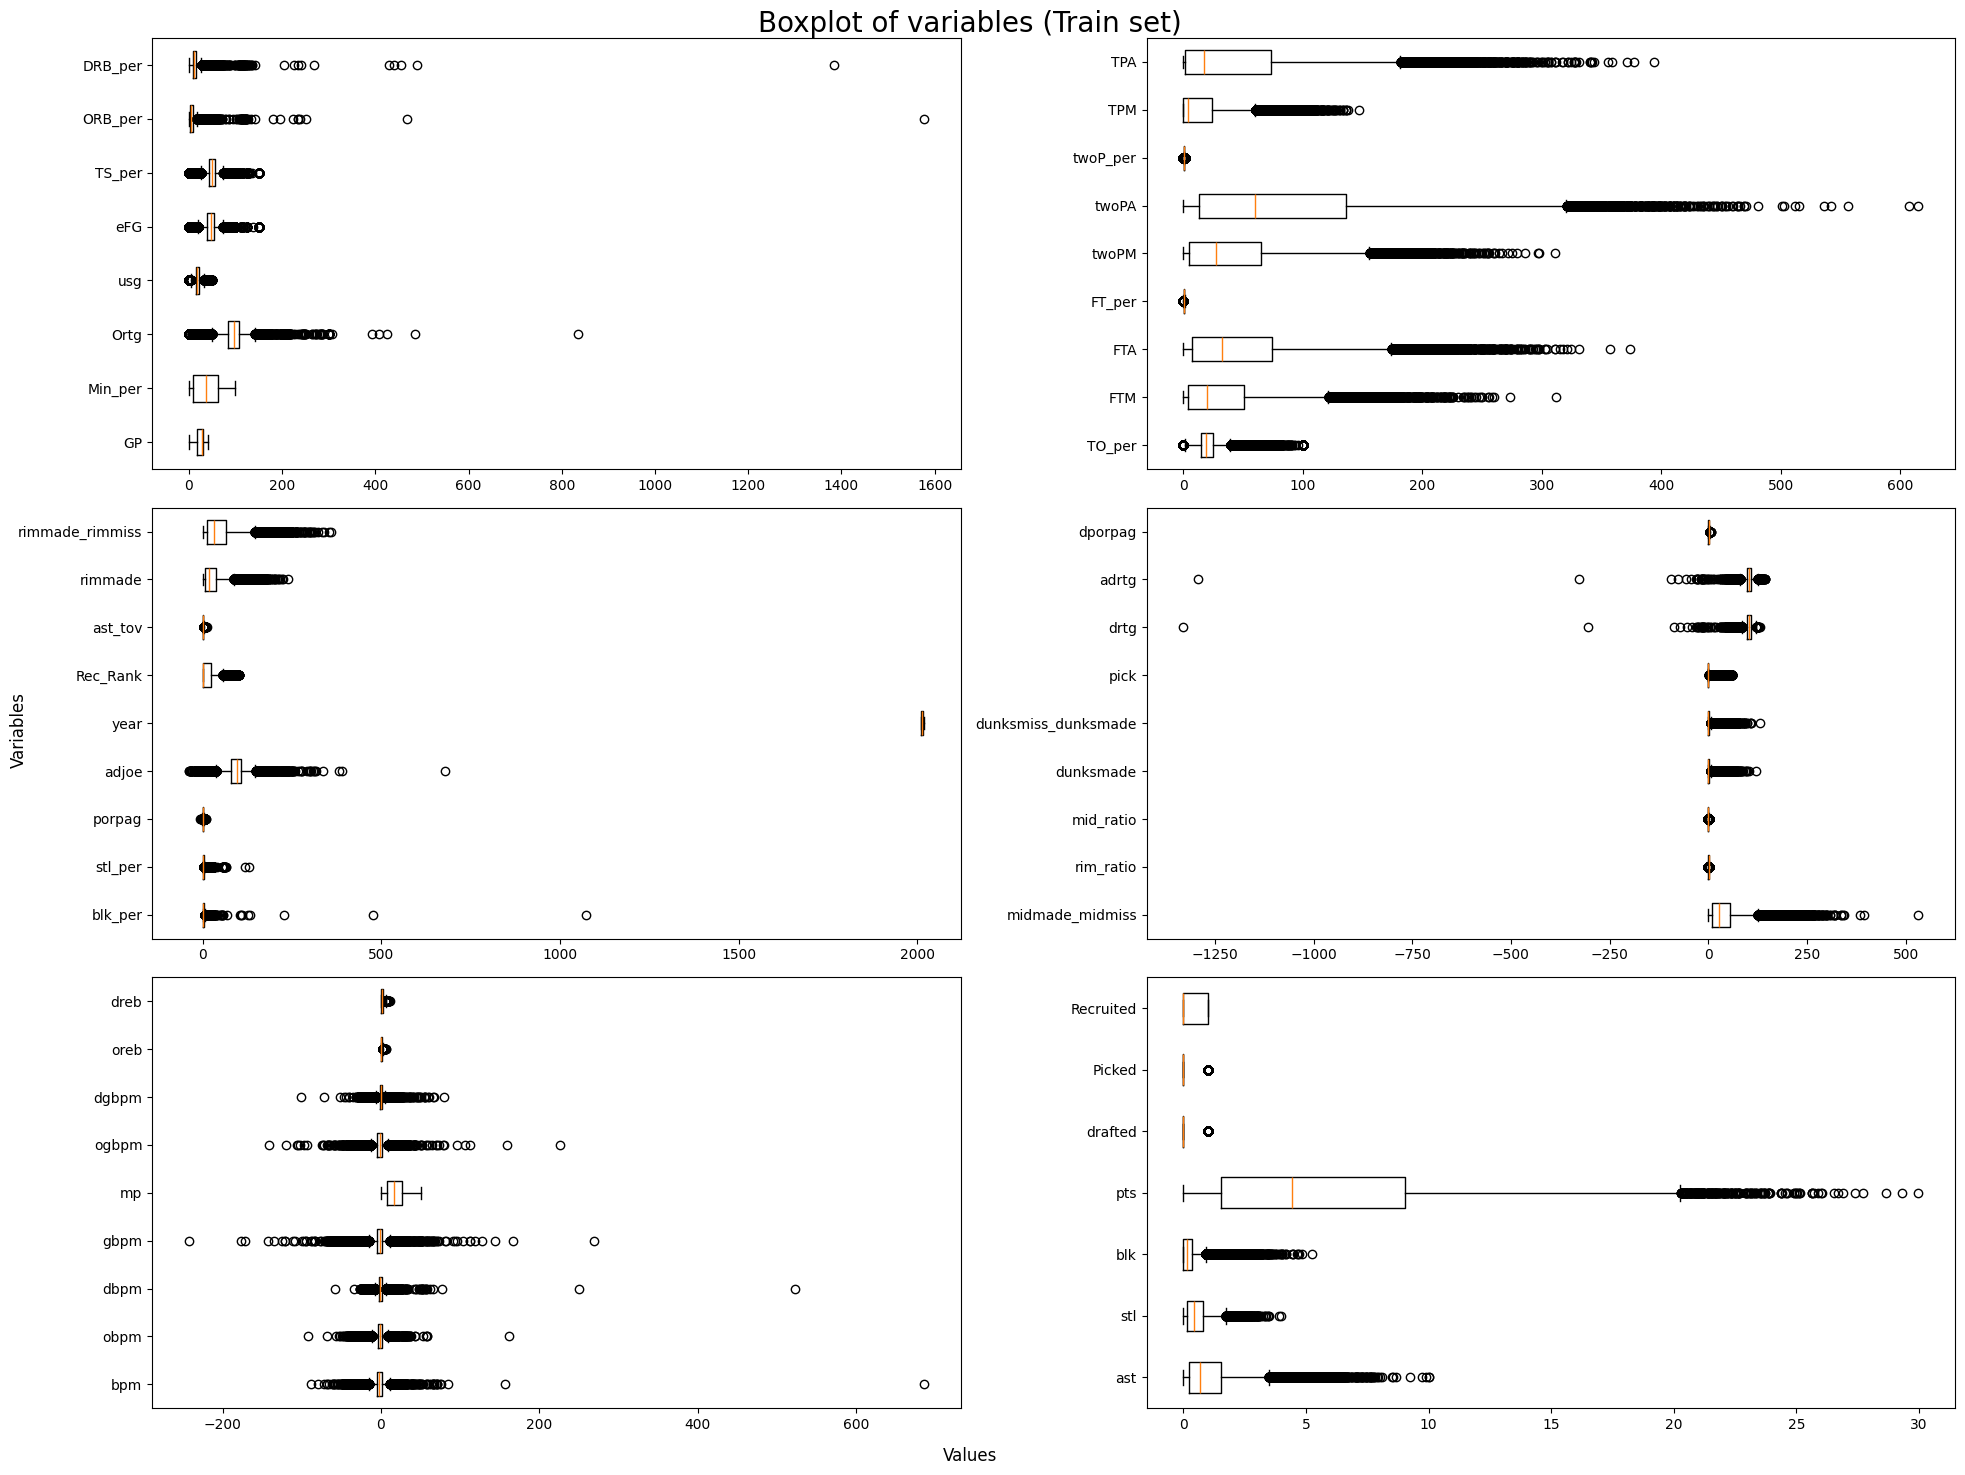

In [222]:
#Iterate the list of variables to plot boxplots
numvar = df_train2.select_dtypes(include = np.number).columns
var_range = [(0, 8), (9, 18), (19, 28), (29, 38), (39, 48), (49, 60)]

fig, axes = plt.subplots(3, 2, figsize=(20,15))

for i, (a,b) in enumerate(var_range):
    var = numvar[a:b]
    data = [df_train2[col].dropna().values for col in var]
    ax = axes[i//2, i%2]
    ax.boxplot(data, vert=False, tick_labels=var)

fig.suptitle(f'Boxplot of variables (Train set)', size=20)
fig.supxlabel('Values')
fig.supylabel('Variables')
plt.tight_layout()
# plt.savefig('outlier.png')
plt.show()


* Obviously, outliers are detected across multiple variables. Extreme outliers will highly distort the model performance and predictability, therefore they will be addressed by IQR method.

**Handling Outliers with IQR method**

In [223]:
#Train set
var = ['ORB_per', 'DRB_per', 'blk_per', 'drtg', 'adrtg']

for col in var:
    Q1 = df_train2[col].quantile(0.25)
    Q3 = df_train2[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_train2 = df_train2[(df_train2[col] >= lower_bound) & (df_train2[col] <= upper_bound)]

df_train2.describe(include='all')

,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,yr,porpag,adjoe,year,type,Rec_Rank,ast_tov,rimmade,rimmade_rimmiss,midmade,midmade_midmiss,rim_ratio,mid_ratio,dunksmade,dunksmiss_dunksmade,pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,player_id,drafted,Picked,Recruited
count,41276,41276,41276.000000,41276.000000,41276.00000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41062,41276.000000,41276.000000,41276.000000,41276,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276.000000,41276,41276.000000,41276.000000,41276.000000
unique,355,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18814,NaN,NaN,NaN
top,Penn,A10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jr,NaN,NaN,NaN,all,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,c6a43e58-d8ad-478f-bbc0-dbc880e29142,NaN,NaN,NaN
freq,154,1616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11092,NaN,NaN,NaN,41276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN
mean,NaN,NaN,24.282392,39.229169,92.44719,18.169634,44.874331,48.106386,4.895230,11.603050,11.441281,20.585721,34.895678,49.601027,0.600705,42.159584,88.224319,0.427657,17.101827,49.501066,0.242245,1.307147,1.687235,NaN,0.813217,89.986361,2013.520738,NaN,16.176756,0.959321,26.576025,45.236578,14.420826,40.909245,0.562844,0.325704,2.819387,3.174750,0.786026,104.245385,104.344978,1.459323,85.145234,-2.575603,-1.679996,-0.895692,-2.596475,17.706624,-1.959332,-0.637230,0.754079,1.874655,2.628795,1.155548,0.556970,0.223855,5.994325,NaN,0.008165,0.023355,0.307539
std,NaN,NaN,9.511186,27.763210,27.95672,5.865000,16.570441,15.857189,3.810372,5.373759,8.923157,11.379370,37.585701,50.106389,0.253164,42.828758,84.469438,0.177985,22.098891,58.940613,0.183673,1.499922,1.170708,NaN,1.355988,28.553654,2.874594,NaN,28.728715,0.671656,27.369180,43.623728,16.853504,42.708868,0.167651,0.149940,6.341450,6.975851,5.670202,6.279304,7.594576,1.030187,63.433952,5.991332,4.505743,2.648985,7.209597,10.478583,5.495239,2.523313,0.707437,1.400116,1.992482,1.199131,0.472476,0.285047,4.949057,NaN,0.089989,0.151030,0.461480
min,NaN,NaN,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,-6.792410,-39.021300,2009.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,86.690000,83.003300,0.002508,0.043486,-60.047800,-43.195100,-26.661400,-142.114000,0.000000,-106.262000,-40.672400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,19.000000,12.700000,84.90000,14.700000,40.600000,44.350000,1.800000,8.200000,5.400000,15.100000,5.000000,9.000000,0.516000,7.000000,17.000000,0.376000,0.000000,2.000000,0.000000,0.000000,1.000000,NaN,-0.160896,80.154725,2011.000000,NaN,0.000000,0.500150,6.000000,12.000000,3.000000,10.000000,0.500000,0.274500,0.000000,0.000000,0.000000,99.957575,99.028950,0.589522,25.72940

### 3. Explore variables

**[3.1] Target variable**

In [224]:
# draft_prob = df_train2.drafted.value_counts(normalize=True)
# fig, ax = plt.subplots()
# draft_prob.plot(kind='bar', ax=ax).set_title('Target proportion')
# ax.set_xlabel('Drafted')
# ax.set_ylabel('Probability')
# ax.set_xticklabels([0,1], rotation=0)
# ax.grid(False)
# plt.show()

* The target class is extremely imbalanced.

In [225]:
# #Games played by year
# ax=sns.histplot(df_train2['GP'][df_train2['drafted']==0], edgecolor='white', kde=True, color='skyblue')
# ax=sns.histplot(df_train2['GP'][df_train2['drafted']==1], edgecolor='white', kde=True, color='orange')
# ax.legend(['drafted 0', 'drafted 1'])
# ax.set_title('Number of games played by draft')
# plt.show()

* Players who played more games seem to have higher chances of being drafted.

In [226]:
# ax=sns.kdeplot(df_train2['mp'][df_train2['drafted']==0], color='Skyblue', fill=True)
# ax=sns.kdeplot(df_train2['mp'][df_train2['drafted']==1], color='Orange', fill=True)
# ax.legend(['drafted 0', 'drafted 1'])
# ax.set_title('Minutes played by draft')

* Players who played more minutes in the season tend to have higher chances of being drafted.

**Categorical variables**

In [227]:
df_train2['type'].value_counts()

type
all    41276
Name: count, dtype: int64

**Count unique values of student's year of study**

In [228]:
df_train2['yr'].value_counts()

yr
Jr      11092
Fr      10688
So       9686
Sr       9591
0           3
57.1        1
42.9        1
Name: count, dtype: int64

* There is only one 'type' in the dataset. In other words, it is not useful for prediction and, therefore, will be dropped.
* Regarding the student's year of study ('yr'), some numeric values were found in the data, which are invalid in this categorical variable. The invalid values will be propagated by the previous valid value.

**Drop attribute 'type'**

In [229]:
df_train2 = df_train2.drop(['type'], axis=1)
df_test2 = df_test2.drop(['type'], axis=1)

**Remove invalid values existing in student's year of study**

In [230]:
#Transform 'yr' type to string
df_train2['yr'] = df_train2['yr'].astype(str)
df_test2['yr'] = df_test2['yr'].astype(str)

#Fill invalid values with the previous valid values  
df_train2['yr'] = df_train2['yr'].replace(['nan', '0', '57.1', '42.9'], np.nan)
df_train2['yr'] = df_train2['yr'].ffill()
df_test2['yr'] = df_test2['yr'].replace(['nan', '0'], np.nan)
df_test2['yr'] = df_test2['yr'].ffill()

In [231]:
print("Train:", df_train.shape)
print("Test:", df_test.shape)

Train: (46618, 60)
Test: (4970, 59)


**Check if the invalid values are addressed**

In [232]:
print("Train:\n", df_train2['yr'].value_counts())
print("\nTest:\n", df_test2['yr'].value_counts())

Train:
 yr
Jr    11151
Fr    10788
So     9715
Sr     9622
Name: count, dtype: int64

Test:
 yr
Fr    1328
Jr    1318
So    1233
Sr    1091
Name: count, dtype: int64


### 4. Prepare Data

**[4.1] Create a copy of dataframe**

In [233]:
df_train_cleaned = df_train2.copy()
df_test_cleaned = df_test2.copy()

**[4.2] Extract the target from dataframe**

In [234]:
y_data = df_train_cleaned.pop('drafted')
y = y_data.copy()

In [235]:
#Frequency of target variable
y_data.value_counts(normalize=True)

drafted
0.0    0.991835
1.0    0.008165
Name: proportion, dtype: float64

**[4.3] Create a list of numeric and categorical variables respectively**

In [236]:
num_cols = list(df_train_cleaned.select_dtypes('number').columns)
cat_cols = list(set(df_train_cleaned.columns) - set(num_cols))

num_cols2 = list(df_test_cleaned.select_dtypes('number').columns)
cat_cols2 = list(set(df_test_cleaned.columns) - set(num_cols2))

**[4.4] Import scaler and encoding**

In [237]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

**[4.65 Encoding categorical variable**

In [238]:
ohe = OneHotEncoder(sparse_output=False, drop='first')

#Transform the column
features_train = ohe.fit_transform(df_train_cleaned[['yr']])
features_test = ohe.transform(df_test_cleaned[['yr']])

In [239]:
#Convert to dataframes
features_train = pd.DataFrame(features_train, columns=ohe.get_feature_names_out())
features_test = pd.DataFrame(features_test, columns=ohe.get_feature_names_out())

**[4.6] Scaling and fit transform numeric features**

In [240]:
scaler = StandardScaler()

In [241]:
#Fit transform
features_train[num_cols] = scaler.fit_transform(df_train_cleaned[num_cols])
features_test[num_cols2] = scaler.transform(df_test_cleaned[num_cols2])

### 5. Split the dataset

In [242]:
X_train = features_train.copy()
X_test = features_test.copy()

**Import package and split the data**

In [243]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_data, test_size=0.2, random_state=8)

**Dimension**

In [244]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(33020, 58)
(8256, 58)
(4970, 58)


**Target proportion**

In [245]:
print(y_train.value_counts(normalize=True))
print(y_val.value_counts(normalize=True))

drafted
0.0    0.991763
1.0    0.008237
Name: proportion, dtype: float64
drafted
0.0    0.992127
1.0    0.007873
Name: proportion, dtype: float64


In [246]:
# X_train.to_csv('../data/processed/X_train2.csv', index=False)
# X_val.to_csv('../data/processed/X_val2.csv', index=False)
# X_test.to_csv('../data/processed/X_test2.csv', index=False)
# y_train.to_csv('../data/processed/y_train2.csv', index=False)
# y_val.to_csv('../data/processed/y_val2.csv', index=False)

### 6. Train RandomForest - Hyperparameter Tuning with RandomSearchCV

**[6.1] Instantiate and fit the model**

In [247]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=8)

**[6.2] Parameters dictionary**

In [248]:
from scipy.stats import randint

param_ran = {
    'n_estimators': randint(5, 100),
    'max_depth': randint(5, 30),
    'min_samples_leaf': randint(10, 100),
    'max_features': randint(2, 30)
}

**[6.3] Instantiate and fit the hyperparameters wit Stratified KFold**

In [249]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)
ransearch = RandomizedSearchCV(rf, param_ran, cv=skf, random_state=8)

In [250]:
ransearch.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=8, shuffle=True),
                   estimator=RandomForestClassifier(random_state=8),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F8569B9D90>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F835FE8FD0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F835FE9210>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F853883590>},
                   random_state=8)

**[6.4] Display the best set of parameters**

In [251]:
ransearch.best_params_

{'max_depth': 8,
 'max_features': 22,
 'min_samples_leaf': 15,
 'n_estimators': 95}

**[6.5] Evaluation metrics for hyperparameters**

In [252]:
ransearch.best_score_

np.float64(0.995336159903089)

In [253]:
print("RanCV_Train:", f'{ransearch.score(X_train, y_train):.4f}')
print("RanCV_val:", f'{ransearch.score(X_val, y_val):.4f}')

RanCV_Train: 0.9972
RanCV_val: 0.9960


**[6.2] Make prediction on training data**

In [254]:
y_train_pred = ransearch.best_estimator_.predict_proba(X_train)[:, 1]
y_val_pred = ransearch.best_estimator_.predict_proba(X_val)[:, 1]

**[6.3] Performance metric - AUROC**

In [255]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [256]:
print("Train - AUROC:\n", f'{roc_auc_score(y_train, y_train_pred):.4f}')
print("Val - AUROC:\n", f'{roc_auc_score(y_val, y_val_pred):.4f}')

Train - AUROC:
 0.9993
Val - AUROC:
 0.9988


**Plot the AUROC curve**

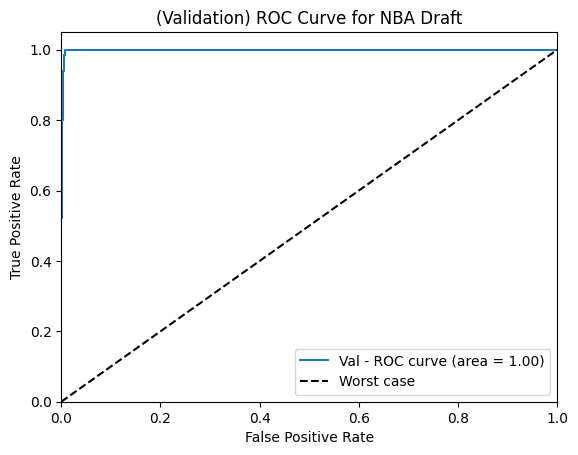

In [257]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred) 
roc_auc = auc(fpr, tpr)
plt.figure()  
plt.plot(fpr, tpr, label='Val - ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Worst case')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(Validation) ROC Curve for NBA Draft')
plt.legend()
plt.show()

**[6.8] Predict on test data**

In [258]:
y_test_pred = ransearch.best_estimator_.predict_proba(X_test)[:, 1]

#Dataframe for pred result
y_test = df_test_cleaned[['player_id']].copy()
y_pred = y_test
y_pred.loc[:, 'drafted'] = y_test_pred

print(y_pred.describe().round(5))

y_pred = pd.DataFrame(y_pred)

#Save the result to CSV file
# y_pred.to_csv('../data/external/at1_pred_week2.3.csv', index=False)

          drafted
count  4970.00000
mean      0.00396
std       0.04495
min       0.00000
25%       0.00000
50%       0.00000
75%       0.00000
max       0.86218


### 7. Feature Importance

In [259]:
feature = ransearch.best_estimator_.feature_importances_

In [260]:
#Dataframe of feature importance
feat_imp_rf_df = pd.DataFrame(
    {'feature': X_train.columns,
     'feature_importance': feature})

In [261]:
#Sort the dataframe
feat_imp_rf_df = feat_imp_rf_df.sort_values('feature_importance', ascending=False).reset_index(drop=True)
# feat_imp_rf_df

In [262]:
#Visualize the feature importance
import altair as alt

alt.Chart(feat_imp_rf_df).mark_bar().encode(
    x='feature_importance',
    y=alt.Y("feature", sort='-x'),
    tooltip=['feature','feature_importance']
)

alt.Chart(...)

### 8. Feature Engineering

* Based on feature importance done in the previous experiment, the least significant features will be excluded in this experiment.

In [263]:
#list the features
features_train.columns

Index(['yr_Jr', 'yr_So', 'yr_Sr', 'GP', 'Min_per', 'Ortg', 'usg', 'eFG',
       'TS_per', 'ORB_per', 'DRB_per', 'AST_per', 'TO_per', 'FTM', 'FTA',
       'FT_per', 'twoPM', 'twoPA', 'twoP_per', 'TPM', 'TPA', 'TP_per',
       'blk_per', 'stl_per', 'porpag', 'adjoe', 'year', 'Rec_Rank', 'ast_tov',
       'rimmade', 'rimmade_rimmiss', 'midmade', 'midmade_midmiss', 'rim_ratio',
       'mid_ratio', 'dunksmade', 'dunksmiss_dunksmade', 'pick', 'drtg',
       'adrtg', 'dporpag', 'stops', 'bpm', 'obpm', 'dbpm', 'gbpm', 'mp',
       'ogbpm', 'dgbpm', 'oreb', 'dreb', 'treb', 'ast', 'stl', 'blk', 'pts',
       'Picked', 'Recruited'],
      dtype='object')

In [264]:
to_keep = ['pick', 'Picked', 'yr_Jr', 'yr_So', 'yr_Sr', 'porpag', 'dporpag', 
            'Rec_Rank', 'pts', 'stops', 'twoPA', 'adjoe', 'ogbpm', 'FTA',
           'twoPM', 'bpm',  'gbpm', 'midmade_midmiss', 'rimmade_rimmiss',
           'FTM', 'mp', 'usg', 'rimmade', 'dunksmiss_dunksmade', 'obpm', 
           'TPM', 'dbpm', 'twoP_per', 'dunksmade', 'TP_per']

In [265]:
X_train = features_train[to_keep]
X_test = features_test[to_keep]

**Import package and split the data**

In [266]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, random_state=8)

**Dimension**

In [267]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(33020, 30)
(8256, 30)
(4970, 30)


**Target proportion**

In [268]:
print(y_train.value_counts(normalize=True))
print(y_val.value_counts(normalize=True))

drafted
0.0    0.991763
1.0    0.008237
Name: proportion, dtype: float64
drafted
0.0    0.992127
1.0    0.007873
Name: proportion, dtype: float64


In [269]:
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()

### 9. Train RandomForest - Hyperparameter Tuning with RandomSearchCV

**[9.1] Instantiate and fit the model**

In [270]:
from sklearn.ensemble import RandomForestClassifier
rf2 = RandomForestClassifier(random_state=8)

**[9.2] Parameters dictionary**

In [271]:
from scipy.stats import randint

params = {
    'n_estimators': randint(5, 100),
    'max_depth': randint(5, 30),
    'min_samples_leaf': randint(10, 100),
    'max_features': randint(2, 30)
}

**[9.3] Instantiate and fit the hyperparameters wit Stratified KFold**

In [272]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)
ransearch2 = RandomizedSearchCV(rf2, params, cv=skf, random_state=8)

In [273]:
ransearch2.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=8, shuffle=True),
                   estimator=RandomForestClassifier(random_state=8),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F8532A9110>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F855ED9450>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F855F38ED0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F8530B5050>},
                   random_state=8)

**[9.4] Display the best set of parameters**

In [274]:
ransearch2.best_params_

{'max_depth': 8,
 'max_features': 22,
 'min_samples_leaf': 15,
 'n_estimators': 95}

**[9.5] Evaluation metrics for hyperparameters**

In [275]:
ransearch2.best_score_

np.float64(0.9958812840702604)

In [276]:
print("RanCV_Train:", f'{ransearch2.score(X_train, y_train):.4f}')
print("RanCV_val:", f'{ransearch2.score(X_val, y_val):.4f}')

RanCV_Train: 0.9972
RanCV_val: 0.9969


**[9.6] Make prediction on training and validation data**

In [277]:
y_train_pred = ransearch2.best_estimator_.predict_proba(X_train)[:, 1]
y_val_pred = ransearch2.best_estimator_.predict_proba(X_val)[:, 1]

**[9.7] Performance metric - AUROC**

In [278]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [279]:
print("Train - AUROC:\n", f'{roc_auc_score(y_train, y_train_pred):.4f}')
print("Val - AUROC:\n", f'{roc_auc_score(y_val, y_val_pred):.4f}')

Train - AUROC:
 0.9993
Val - AUROC:
 0.9988


**Plot the AUROC curve**

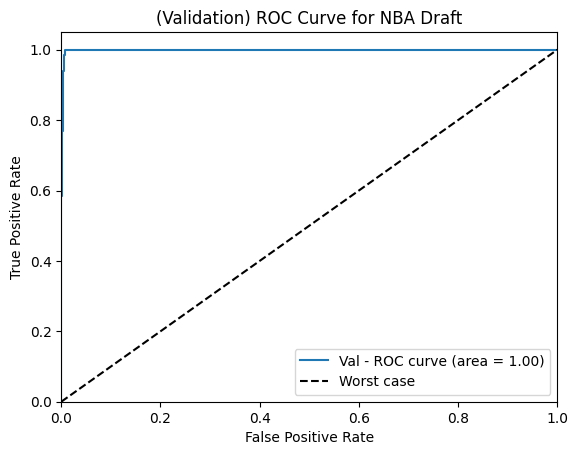

In [280]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred) 
roc_auc = auc(fpr, tpr)
plt.figure()  
plt.plot(fpr, tpr, label='Val - ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Worst case')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(Validation) ROC Curve for NBA Draft')
plt.legend()
plt.show()

**[9.8] Predict on test data**

In [281]:
y_test_pred = ransearch2.best_estimator_.predict_proba(X_test)[:, 1]

#Dataframe for pred result
y_pred = y_test
y_pred.loc[:, 'drafted'] = y_test_pred

print(y_pred.describe().round(5))

y_pred = pd.DataFrame(y_pred)

#Save the result to CSV file
# y_pred.to_csv('../data/external/at1_pred_week2.4.csv', index=False)

          drafted
count  4970.00000
mean      0.00419
std       0.04921
min       0.00000
25%       0.00000
50%       0.00000
75%       0.00000
max       0.93937


### 10. Feature Importance

In [282]:
feature = ransearch2.best_estimator_.feature_importances_

In [283]:
#Dataframe of feature importance
feat_imp_rf_df = pd.DataFrame(
    {'feature': X_train.columns,
     'feature_importance': feature})

In [284]:
#Sort the dataframe
feat_imp_rf_df = feat_imp_rf_df.sort_values('feature_importance', ascending=False).reset_index(drop=True)
# feat_imp_rf_df

In [285]:
#Visualize the feature importance
alt.Chart(feat_imp_rf_df).mark_bar().encode(
    x='feature_importance',
    y=alt.Y("feature", sort='-x'),
    tooltip=['feature','feature_importance']
)

alt.Chart(...)